# Model training and evaluation

This notebook includes the model training and evaluation for DeepLabv3 with ResNet101 and MobileNetV3 backbone layers.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn.functional as F
import timm
from torchvision import models

from utils import (
    get_device, pixel_accuracy, iou_score, dice_score,
    f1_score, batch_files, files_to_tensors
)

## Importing dataset

Data we use consist of POEM images and a corresponding 2D tensor comprising of the each pixel's label. The images are imported from a local directory and the tensors are store in a pickled dictionary containing the image file name as keys and tensors as values.

In [2]:
im_dir = "/Users/naman/Workspace/Data/BM5020-POEM/Annotated"

pkl_path = f"{im_dir}/annotations.pkl"
# pkl_path = "segmented_images.pkl"

with open(pkl_path, "rb") as file:
    data_dict = pickle.load(file)

data_dict

{'M_01022024131810_20698051_1_001_0001-01.MP4-frame7130.jpg': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'M_01112024131028_20696889_1_001_0002-01.MP4-frame5946.jpg': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'M_01022024131810_20698051_1_001_0002-01.MP4-frame58581.jpg': tensor([[2, 2, 2,  ..., 0, 0, 0],
         [2, 2, 2,  ..., 0, 0, 0],
         [2, 2, 2,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'M_01092024123848_20698524_1_001_0001-01.MP4-frame49654.jpg': tensor([[2, 2, 2,  ..., 0, 0, 0],
         [2, 2, 2,  ..., 0, 0, 0],
      

## Data preprocessing

Here 

In [3]:
all_files = list(data_dict.keys())

batch_size = 4
batched_files = batch_files(all_files, batch_size)

batched_files

[array(['M_01022024131810_20698051_1_001_0001-01.MP4-frame7130.jpg',
        'M_01112024131028_20696889_1_001_0002-01.MP4-frame5946.jpg',
        'M_01022024131810_20698051_1_001_0002-01.MP4-frame58581.jpg',
        'M_01092024123848_20698524_1_001_0001-01.MP4-frame49654.jpg'],
       dtype='<U58'),
 array(['M_01022024131810_20698051_1_001_0002-01.MP4-frame61918.jpg',
        'M_01022024131810_20698051_1_001_0002-01.MP4-frame68805.jpg',
        'M_01022024131810_20698051_1_001_0001-01.MP4-frame7780.jpg',
        'M_01022024131810_20698051_1_001_0001-01.MP4-frame5791.jpg'],
       dtype='<U58'),
 array(['M_01092024123848_20698524_1_001_0001-01.MP4-frame23206.jpg',
        '1.jpg', '2.jpg', '3.jpg'], dtype='<U58'),
 array(['4.jpg', '5.jpg', '6.jpg', '7.jpg'], dtype='<U58'),
 array(['8.jpg', '9.jpg', '10.jpg'], dtype='<U58')]

## Loading the models

We load the models with classifier head as DeepLabv3 with 2 different backbones: Resnet101 and MobileNetV3. The classifier head in our model is used to classify each pixel and the backbone layer is used for feature extraction. Backbone layers are initialised with pretrained weights whereas the classifier head is initialised with random weights and 4 number of classes.

In [4]:
device = get_device()

In [5]:
classes = 4

deeplabv3_weights = models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
resnet101_weights = models.ResNet101_Weights.IMAGENET1K_V2
mobilenetv3_weights = models.mobilenet.MobileNet_V3_Large_Weights.IMAGENET1K_V2

deeplabv3_resnet101 = models.segmentation.deeplabv3.deeplabv3_resnet101(
    num_classes=classes, weights_backbone=resnet101_weights
).to(device)
deeplabv3_mobilenetv3 = models.segmentation.deeplabv3.deeplabv3_mobilenet_v3_large(
    num_classes=classes, weights_backbone=mobilenetv3_weights
).to(device)

In [6]:
deeplabv3_resnet101

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [7]:
deeplabv3_mobilenetv3

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

## Loading the optimizer and scheduler

We use the Adam optimizer with exponential scheduling. $\gamma$ in our scheduler is the factor multiplied after each step of the scheduler (which is taken after every epoch). Hence, the learning rate at $i\text{th}$ epoch will be $\text{initial\_lr} * \gamma^i$.

In [9]:
initial_lr = 1e-2
optimizer = torch.optim.Adam(deeplabv3_mobilenetv3.parameters(), lr=initial_lr)

gamma = 0.8
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

## Model training

In [10]:
loss_list = []
accuracy_list = []
iou_list = [[] for _ in range(classes)]
dice_list = [[] for _ in range(classes)]
f1_list = [[] for _ in range(classes)]

lr_vals = []

epochs = 40
batches = len(batched_files)
for epoch in range(epochs):

    epoch_loss = 0
    epoch_accuracy = 0
    epoch_iou_list = [0] * classes
    epoch_dice_list = [0] * classes
    epoch_f1_list = [0] * classes

    for batch in batched_files:

        inputs, labels = files_to_tensors(batch, im_dir, data_dict)
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = deeplabv3_mobilenetv3(inputs)

        logits = output["out"]

        loss = F.cross_entropy(logits, labels)
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

        predictions = logits.argmax(dim=1).cpu()
        labels = labels.cpu()
        epoch_accuracy += pixel_accuracy(predictions, labels)

        for i in range(classes):
            epoch_iou_list[i] += iou_score(predictions == i, labels == i)
            epoch_dice_list[i] += dice_score(predictions == i, labels == i)
            epoch_f1_list[i] += f1_score(predictions == i, labels == i)

    lr_val = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_vals.append(lr_val)
    scheduler.step()

    print(f"Epoch {epoch + 1}/{epochs} average loss: {epoch_loss / batches}")

    loss_list.append(epoch_loss / batches)
    accuracy_list.append(epoch_accuracy / batches)
    for i in range(classes):
        iou_list[i].append(epoch_iou_list[i] / batches)
        dice_list[i].append(epoch_dice_list[i] / batches)
        f1_list[i].append(epoch_f1_list[i] / batches)

/Users/naman/Workspace/Code/Python/BM5020-Project/utils.py:94: RuntimeWarning: invalid value encountered in divide
  iou_scores = intersection.sum(axis=0) / union.sum(axis=0)
/Users/naman/Workspace/Code/Python/BM5020-Project/utils.py:103: RuntimeWarning: invalid value encountered in divide
  dice_scores = intersection.sum(axis=0) / (predicted_labels.sum(axis=0) + true_labels.sum(axis=0))
/Users/naman/Workspace/Code/Python/BM5020-Project/utils.py:112: RuntimeWarning: invalid value encountered in divide
  precisions = intersection.sum(axis=0) / predicted_labels.sum(axis=0)
/Users/naman/Workspace/Code/Python/BM5020-Project/utils.py:113: RuntimeWarning: invalid value encountered in divide
  recalls = intersection.sum(axis=0) / true_labels.sum(axis=0)
/Users/naman/Workspace/Code/Python/BM5020-Project/utils.py:114: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * precisions * recalls / (precisions + recalls)


Epoch 1/40 average loss: 1.6438872337341308
Epoch 2/40 average loss: 1.8873351335525512
Epoch 3/40 average loss: 2.284350776672363
Epoch 4/40 average loss: 1.7954753398895265
Epoch 5/40 average loss: 1.8798407554626464
Epoch 6/40 average loss: 2.225569319725037
Epoch 7/40 average loss: 1.900477647781372
Epoch 8/40 average loss: 1.6607075214385987
Epoch 9/40 average loss: 1.5108407735824585
Epoch 10/40 average loss: 1.5339839220046998
Epoch 11/40 average loss: 1.5662197113037108
Epoch 12/40 average loss: 1.4119086980819702
Epoch 13/40 average loss: 1.3734477281570434
Epoch 14/40 average loss: 1.313234806060791
Epoch 15/40 average loss: 1.2413819074630736
Epoch 16/40 average loss: 1.2614273071289062
Epoch 17/40 average loss: 1.2588784217834472
Epoch 18/40 average loss: 1.2381757020950317
Epoch 19/40 average loss: 1.2087199926376342
Epoch 20/40 average loss: 1.1822484493255616
Epoch 21/40 average loss: 1.1657777309417725
Epoch 22/40 average loss: 1.1586469173431397
Epoch 23/40 average los

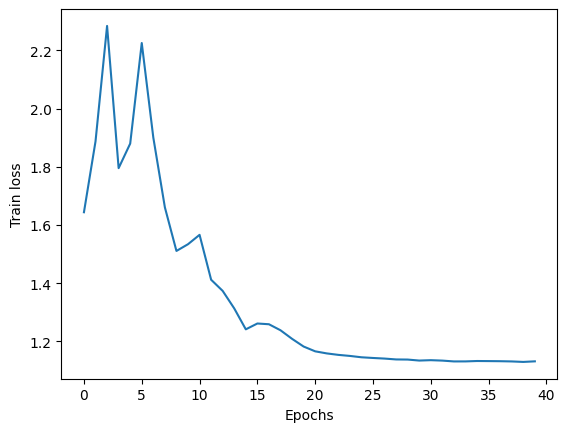

In [11]:
plt.plot(loss_list)
plt.xlabel("Epochs")
plt.ylabel("Train loss")
plt.show()

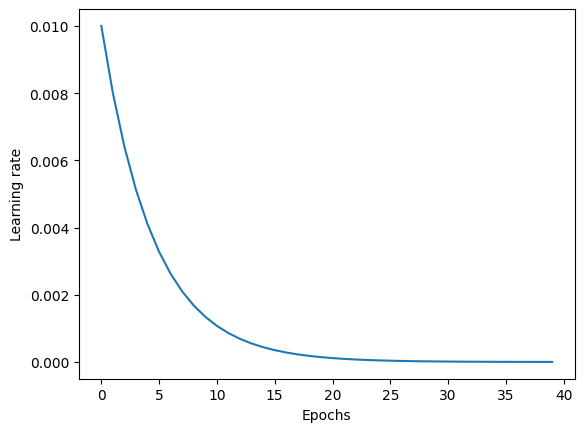

In [12]:
plt.plot(lr_vals)
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.show()

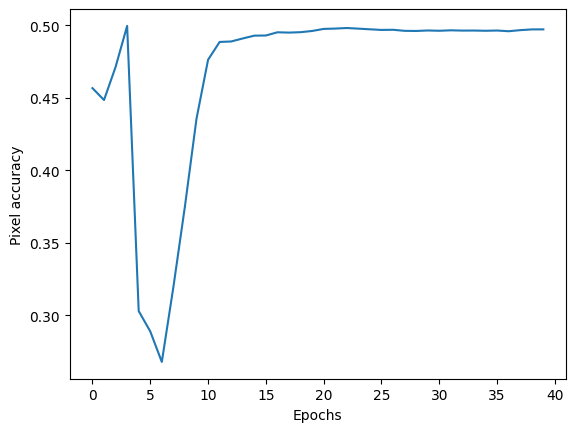

In [13]:
plt.plot(accuracy_list)
plt.xlabel("Epochs")
plt.ylabel("Pixel accuracy")
plt.show()

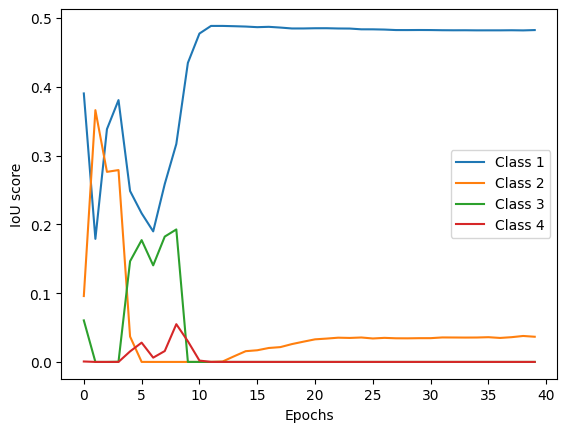

In [17]:
for class_ in range(classes):
    plt.plot(iou_list[class_], label=f"Class {class_ + 1}")
plt.xlabel("Epochs")
plt.ylabel(f"IoU score")
plt.legend()
plt.show()

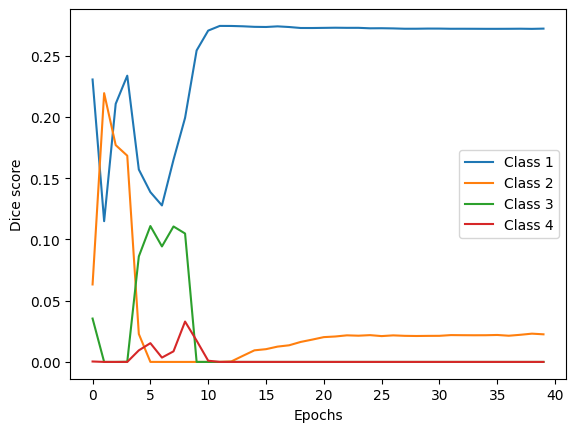

In [18]:
for class_ in range(classes):
    plt.plot(dice_list[class_], label=f"Class {class_ + 1}")
plt.xlabel("Epochs")
plt.ylabel(f"Dice score")
plt.legend()
plt.show()

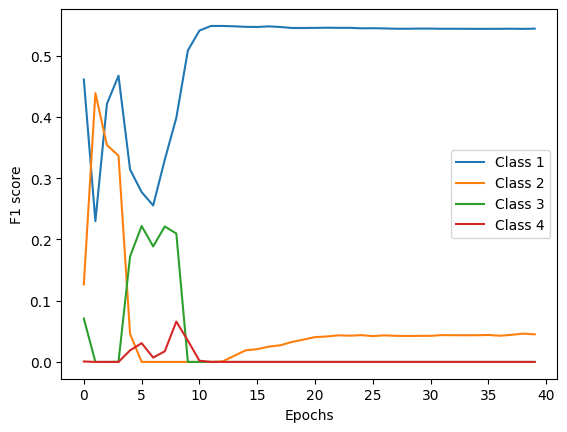

In [19]:
for class_ in range(classes):
    plt.plot(f1_list[class_], label=f"Class {class_ + 1}")
plt.xlabel("Epochs")
plt.ylabel(f"F1 score")
plt.legend()
plt.show()

In [34]:
f1_list[3][-1]

0.0